In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
data = np.loadtxt(open('../00-Dataset/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:, 0]
data = data[:, 1:]

dataNorm = data/np.max(data)

In [3]:
# convert data to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, train_size = 0.9)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchSize = 32
train_loader = DataLoader(train_data, batch_size=batchSize, drop_last=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.__len__())

In [4]:
class Model(nn.Module):
    def __init__ (self):
        super().__init__()

        self.input = nn.Linear(784, 64)
        self.h1 = nn.Linear(64, 32)
        self.h2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, data):
        x = F.relu(self.input(data))
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.output(x)

        return x

In [5]:
def getModelWithSetWeights(sigma):
    ANN = Model()
    lossFunction = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=ANN.parameters(), lr=0.01)

    for p in ANN.named_parameters():
        p[1].data = torch.randn_like(p[1].data) * sigma # set all params according to SD

    return ANN, lossFunction, optimizer

In [6]:
def trainModel(ANN, lossFunction, optimizer):
    epochs = 10

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    for _ in range(epochs):
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            yHat = ANN.forward(x)
            
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        X, Y = next(iter(test_loader))

        with torch.no_grad():
            pred = ANN(X)

        testAcc.append(torch.mean((torch.argmax(pred, axis=1)==Y).float())*100)

    return trainAcc, testAcc, losses, ANN

In [7]:
np.log10(0.0001)

-4.0

In [8]:
sigmas = np.logspace(np.log10(1e-4), np.log10(10), num=25) # 25 log spaced standard deviations between 0.0001 and 10

In [9]:
sigmas

array([1.00000000e-04, 1.61559810e-04, 2.61015722e-04, 4.21696503e-04,
       6.81292069e-04, 1.10069417e-03, 1.77827941e-03, 2.87298483e-03,
       4.64158883e-03, 7.49894209e-03, 1.21152766e-02, 1.95734178e-02,
       3.16227766e-02, 5.10896977e-02, 8.25404185e-02, 1.33352143e-01,
       2.15443469e-01, 3.48070059e-01, 5.62341325e-01, 9.08517576e-01,
       1.46779927e+00, 2.37137371e+00, 3.83118685e+00, 6.18965819e+00,
       1.00000000e+01])

In [10]:
finalRes = np.zeros((len(sigmas), 2))

nHistBins = 80

histoData = np.zeros((len(sigmas), 2, nHistBins))

for i in range(len(sigmas)):
    ANN, lossFunction, optimizer = getModelWithSetWeights(sigmas[i])

    trainAcc, testAcc, losses, ANN = trainModel(ANN, lossFunction, optimizer)

    finalRes[i][0] = sigmas[i]
    finalRes[i][1] = np.mean(testAcc[-3:])

    tempParams = np.array([])
    for p in ANN.named_parameters():
        tempParams = np.concatenate((tempParams, p[1].data.numpy().flatten()), axis=0)

    y, x = np.histogram(tempParams, nHistBins)
    histoData[i, 0, :] = (x[1:]+x[:-1])/2
    histoData[i, 1, :] = y

In [11]:
finalRes

array([[1.00000000e-04, 9.47666702e+01],
       [1.61559810e-04, 9.47999954e+01],
       [2.61015722e-04, 9.29500046e+01],
       [4.21696503e-04, 9.38333359e+01],
       [6.81292069e-04, 9.46833420e+01],
       [1.10069417e-03, 9.41833267e+01],
       [1.77827941e-03, 9.45333328e+01],
       [2.87298483e-03, 9.44166641e+01],
       [4.64158883e-03, 9.42999954e+01],
       [7.49894209e-03, 9.49333267e+01],
       [1.21152766e-02, 9.52833328e+01],
       [1.95734178e-02, 9.52500000e+01],
       [3.16227766e-02, 9.52999954e+01],
       [5.10896977e-02, 9.50833359e+01],
       [8.25404185e-02, 9.51166687e+01],
       [1.33352143e-01, 9.58666687e+01],
       [2.15443469e-01, 9.47999954e+01],
       [3.48070059e-01, 9.44500046e+01],
       [5.62341325e-01, 9.27666626e+01],
       [9.08517576e-01, 2.23500004e+01],
       [1.46779927e+00, 1.24000006e+01],
       [2.37137371e+00, 1.21333342e+01],
       [3.83118685e+00, 1.11999998e+01],
       [6.18965819e+00, 6.46166687e+01],
       [1.000000

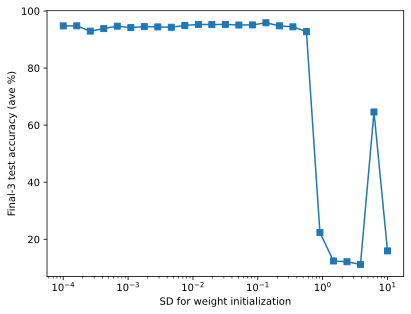

In [15]:


plt.plot(finalRes[:, 0],finalRes[:, 1] ,'s-')
plt.xlabel('SD for weight initialization')
plt.ylabel('Final-3 test accuracy (ave %)')
plt.xscale('log')
plt.show()

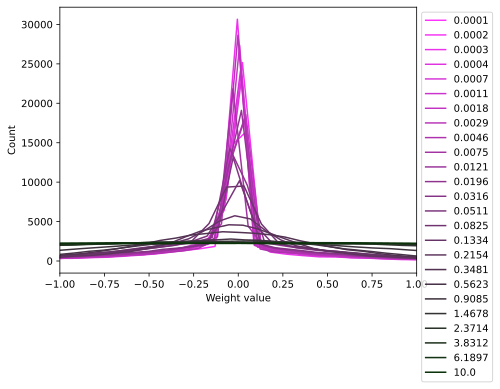

In [17]:
for i in range(len(sigmas)):
  plt.plot(histoData[i,0,:],histoData[i,1,:],color=[1-i/len(sigmas),.2,1-i/len(sigmas)])

plt.xlabel('Weight value')
plt.ylabel('Count')
plt.legend(np.round(sigmas,4),bbox_to_anchor=(1,1),loc='upper left')
plt.xlim([-1,1])
plt.show()